Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [23]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36


In [24]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [36]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [37]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.0 1.0
-0.7385716593761336 1.5644087294939895


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [38]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
## function which map object to probability distribution ##

def bin_counts (real_data, generated_data, number_of_bins=25):
    # binirize real and generated data, plot histogram and found density function
    cluster_data = np.vstack([real_data, generated_data])
    kmeans = MiniBatchKMeans(n_clusters=number_of_bins, n_init=10)
    labels = kmeans.fit(cluster_data).labels_

    eval_labels = labels[:len(real_data)]
    ref_labels = labels[len(real_data):]

    real_density = np.histogram(eval_labels, bins=number_of_bins,
                           range=[0, number_of_bins], density=True)[0]
    gen_density = np.histogram(ref_labels, bins=number_of_bins,
                          range=[0, number_of_bins], density=True)[0]
    return real_density, gen_density

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [39]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    
    slopes = np.tan(angles)
    slopes_2d = np.expand_dims(slopes, 1)
    
    ref_dist_2d = np.expand_dims(gen_density, 0)
    eval_dist_2d = np.expand_dims(real_density, 0)
    
    precision = np.minimum(ref_dist_2d*slopes_2d, eval_dist_2d).sum(axis=1)
    recall = precision / slopes
    max_val = max(np.max(precision), np.max(recall))
    if max_val > 1.001:
        raise ValueError('Detected value > 1.001, this should not happen.')
    alpha_vec = np.clip(precision, 0, 1)
    beta_vec = np.clip(recall, 0, 1)
    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [40]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print (vectors.shape)
    return vectors

## 2. Apply it##

(array([9., 1., 2., 2., 2., 4., 3., 1., 0., 1.]),
 array([7.60861295e-05, 1.21205204e-02, 2.41649547e-02, 3.62093890e-02,
        4.82538233e-02, 6.02982576e-02, 7.23426919e-02, 8.43871262e-02,
        9.64315605e-02, 1.08475995e-01, 1.20520429e-01]),
 <a list of 10 Patch objects>)

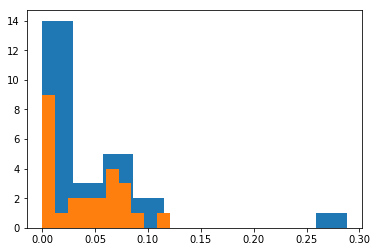

In [41]:
a, b = bin_counts(real_data.image, vae_data.image)
c, d = bin_counts(real_data.image, gan_data.image)
plt.hist(a)
plt.hist(b)

(array([3., 4., 3., 5., 5., 2., 1., 0., 0., 2.]),
 array([0.00076086, 0.01144335, 0.02212585, 0.03280834, 0.04349083,
        0.05417332, 0.06485582, 0.07553831, 0.0862208 , 0.09690329,
        0.10758579]),
 <a list of 10 Patch objects>)

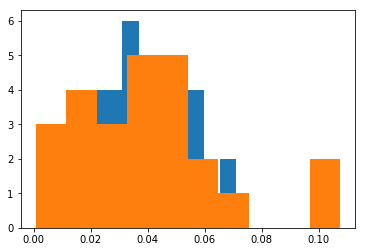

In [42]:
plt.hist(c)
plt.hist(d)

## 3. Make vectors for plot and plot ##

In [43]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

(2, 1000)
(2, 1000)


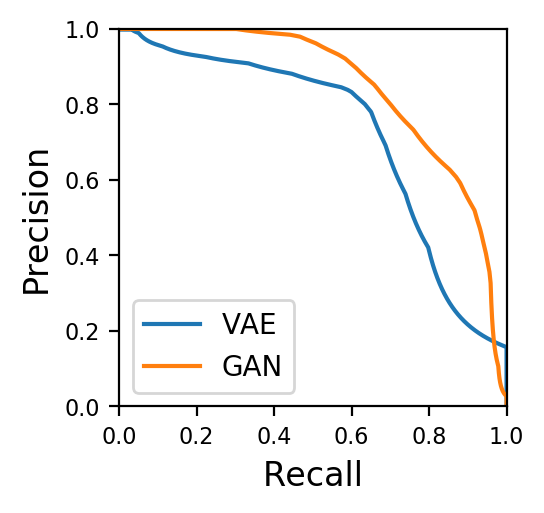

In [44]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

the GAN model achieve higher precision and lower recall than the VAE model, which suffices to successfully distinguishing between the failure cases.

curve successfully demonstrate the sensitivity of GAN.

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [ ]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
